In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

C:\Users\User\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv('transport_data.csv')
data.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


Разделим данные на обучающие и тестовые:

In [3]:
train_data = data[(data['label'] == '0') | (data['label'] == '1') | (data['label'] == '2')].reset_index(drop=True)
train_data['label'] = train_data['label'].astype(int)
train_data.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.385973,59.944260,1511956827,1511956782,0
2,30.374880,59.938213,1511956827,1511956802,1
3,30.347544,59.932667,1511956827,1511956811,0
4,30.312321,59.937405,1511956827,1511956820,2


In [4]:
train_data.shape

(10000, 5)

In [5]:
test_data = data[data['label'] == '?'].reset_index(drop=True)
test_data.head()

,log,lat,request_ts,trans_ts,label
0,30.359190,59.931217,1511956827,1511956787,?
1,30.355488,59.931679,1511956827,1511956811,?
2,30.312258,59.937222,1511956918,1511956905,?
3,30.367332,59.931988,1511956918,1511956907,?
4,30.329239,59.934929,1511956978,1511956967,?


In [6]:
test_data = test_data.drop('label', axis=1)

In [7]:
test_data.shape

(5000, 4)

In [8]:
label = train_data['label'].values.astype(int)
train_data = train_data.drop('label', axis=1)

In [9]:
train_data.head()

,log,lat,request_ts,trans_ts
0,30.295780,59.932167,1511956827,1511956594
1,30.385973,59.944260,1511956827,1511956782
2,30.374880,59.938213,1511956827,1511956802
3,30.347544,59.932667,1511956827,1511956811
4,30.312321,59.937405,1511956827,1511956820


Отдельно выделим данные, маршрут автобусов в которых не размечен:

In [10]:
unlabeled_data = data[data['label'] == '-'].reset_index(drop=True)
unlabeled_data = unlabeled_data.drop('label', axis=1)
unlabeled_data.shape

(43665, 4)

Посмотрим на графики маршрутов обучающих, тестовых и неразмеченных данных:

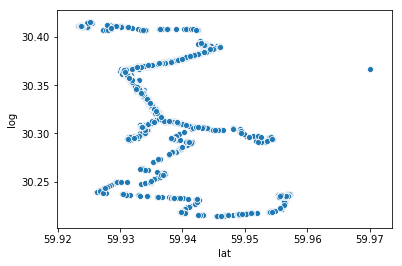

In [11]:
sns.scatterplot(x='lat', y='log', data=train_data)

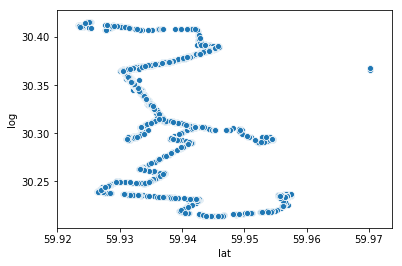

In [12]:
sns.scatterplot(x='lat', y='log', data=test_data)

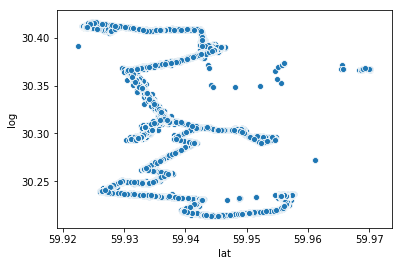

In [13]:
sns.scatterplot(x='lat', y='log', data=unlabeled_data)

Разделим размеченные данные на обучающие и тестовые, на которых будет проверяться эффективность работы моделей:

In [14]:
train, test, y_train, y_test = train_test_split(train_data, label, test_size=0.3, random_state=0, shuffle=True, stratify=label)

In [15]:
train.shape, test.shape, y_train.shape, y_test.shape

((7000, 4), (3000, 4), (7000L,), (3000L,))

#### Логистическая регрессия

Используем логистическую регрессию с поиском параметров по сетке с помощью GridSearchCV. Сначала попробуем предсказать маршрут на основе только данных широты и долготы и посмотрим на оценку работы модели:

In [16]:
cv = 5
log_reg = LR()
param_grid_lr = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
gridCV_lr = GridSearchCV(log_reg, param_grid_lr, scoring = 'accuracy', cv = cv)
gridCV_lr.fit(train[['log', 'lat']], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [17]:
pred = gridCV_lr.predict(test[['log', 'lat']])

In [18]:
accuracy_score(y_test, pred)

0.5036666666666667

Доля правильных ответов достаточно мала, попробуем обучить модель на всей обучающей выборке (широта, долгота и время):

In [19]:
gridCV_lr.fit(train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [20]:
pred = gridCV_lr.predict(test)

In [21]:
accuracy_score(y_test, pred)

0.44233333333333336

Попробуем добиться более высокой оценки с помощью другой модели.

#### Random forest

Используем случайный лес с поиском параметров по сетке с помощью GridSearchCV. Сначала попробуем предсказать маршрут на основе только данных широты и долготы и посмотрим на оценку работы модели:

In [22]:
forest = RFC(random_state=0)
param_grid_rfc = { 
    'n_estimators': [100, 200, 300, 500, 700, 900]
}
gridCV_rfc = GridSearchCV(forest, param_grid_rfc, scoring = 'accuracy', cv = cv)
gridCV_rfc.fit(train[['log', 'lat']], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 500, 700, 900]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [23]:
pred = gridCV_rfc.predict(test[['log', 'lat']])

In [24]:
accuracy_score(y_test, pred)

0.563

Результат получился чуть лучше, чем с логистической регрессией, теперь посмотрим на работу случайного леса на всей обучающей выборке:

In [25]:
gridCV_rfc.fit(train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 500, 700, 900]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [26]:
pred = gridCV_rfc.predict(test)

In [27]:
accuracy_score(y_test, pred)

0.593

Доля правильных ответов стала выше, в дальнейшем будем работать со случайным лесом, поэтому посмотрим на оптимальные параметры, найденные GridSearchCV:

In [28]:
gridCV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Работа с неразмеченными данными

Большую часть исходных данных занимают неразмеченные данные, поэтому обучающая выборка на размеченных данных оказалась слишком маленькой. Попробуем предсказать вероятности принадлежности к тому или иному маршруту в неразмеченных данных и добавим данные с наибольшей вероятностью (>80%) к обучающей выборке.

In [29]:
forest = RFC(n_estimators=900, random_state=0)

In [30]:
forest.fit(train_data.values, label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
proba = forest.predict_proba(unlabeled_data.values)
un_pred = proba.argmax(axis=1)

In [32]:
unlabeled_data['probability'] = proba.max(axis=1)
unlabeled_data['label'] = un_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,probability,label
0,30.219528,59.954617,1511956827,1511956746,0.924444,1
1,30.409101,59.931679,1511956827,1511956747,0.847778,2
2,30.293602,59.938892,1511956827,1511956759,0.753333,1
3,30.360102,59.931103,1511956827,1511956767,0.884444,0
4,30.309683,59.940006,1511956827,1511956769,0.541111,2


In [33]:
labeled_data = unlabeled_data[unlabeled_data['probability'] > 0.8]
labeled_data.head()

,log,lat,request_ts,trans_ts,probability,label
0,30.219528,59.954617,1511956827,1511956746,0.924444,1
1,30.409101,59.931679,1511956827,1511956747,0.847778,2
3,30.360102,59.931103,1511956827,1511956767,0.884444,0
7,30.236233,59.955753,1511956827,1511956783,0.950000,1
8,30.296188,59.932774,1511956827,1511956783,0.974444,0


In [34]:
labeled_data.shape

(27993, 6)

In [35]:
y_labeled = labeled_data['label'].values
labeled_data = labeled_data.drop(['probability', 'label'], axis=1)

In [36]:
train = np.vstack((train.values, labeled_data.values))
y_train = np.concatenate((y_train, y_labeled))

In [37]:
train.shape, y_train.shape

((34993L, 4L), (34993L,))

In [38]:
forest.fit(train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [39]:
pred = forest.predict(test.values)

In [40]:
accuracy_score(y_test, pred)

0.623

Доля правильных ответов увеличилась, попробуем предсказать маршруты со знаком ?:

In [41]:
final_train = np.vstack((train_data.values, labeled_data.values))
y_final = np.concatenate((label, y_labeled))

In [42]:
forest.fit(final_train, y_final)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
final_pred = forest.predict(test_data.values)

In [44]:
with open('prediction.csv', 'w') as f:
    f.write('\n'.join([str(pred) for pred in final_pred]))